<center><h1>Bitcoin</h1></center>
<center>CDASO2020U "Data Mining, Machine Learning and Deep Learning"</center>

<center><h1>Structure</h1></center>

A. [Exploratory data analysis](#A)
1. [Variable Identification](#1)
2. [Variable creation](#2)
3. [Variable transformation](#3)
4. [Subdataset creation](#4)
5. [Univariate Analysis](#5)
6. [Bi-variate Analysis](#6)
7. [Outlier Handling](#7)
8. [Missing values](#8)
9. [PCA for Feature Importance](#9)
10. [Export dataframes](#10)

### Used Packages

In [1]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from plotly import graph_objs as go  #!conda install --yes --prefix {sys.prefix} plotly (for windows users who's cmd sucks)
from plotly.offline import init_notebook_mode, iplot
import pprint
import seaborn as sns
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.externals.six import StringIO
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import pydotplus
import sys

/Users/theresawohlsen/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



# A. Exploratory data analysis <a class="anchor" id="A"></a>

In [2]:
df = pd.read_csv("BitcoinHeistData.csv")

In [3]:
df.head()

,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000.0,princetonCerber
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,100000000.0,princetonLocky
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,200000000.0,princetonCerber
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,71200000.0,princetonCerber
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000.0,princetonLocky


In [4]:
# Checkout some white labeled examples too
df.tail()

,address,year,day,length,weight,count,looped,neighbors,income,label
2916692,12D3trgho1vJ4mGtWBRPyHdMJK96TRYSry,2018,330,0,0.111111,1,0,1,1.255809e+09,white
2916693,1P7PputTcVkhXBmXBvSD9MJ3UYPsiou1u2,2018,330,0,1.000000,1,0,1,4.409699e+07,white
2916694,1KYiKJEfdJtap9QX2v9BXJMpz2SfU4pgZw,2018,330,2,12.000000,6,6,35,2.398267e+09,white
2916695,15iPUJsRNZQZHmZZVwmQ63srsmughCXV4a,2018,330,0,0.500000,1,0,1,1.780427e+08,white
2916696,3LFFBxp15h9KSFtaw55np8eP5fv6kdK17e,2018,330,144,0.073972,6800,0,2,1.123500e+08,white


## 1. Variable Identification  <a class="anchor" id="1"></a>

In [5]:
# Identify all columns
df.columns

Index(['address', 'year', 'day', 'length', 'weight', 'count', 'looped',
       'neighbors', 'income', 'label'],
      dtype='object')

In [6]:
# features
features = ['year', 'day', 'length', 
            'weight', 'count', 'looped',
            'neighbors', 'income']

In [7]:
# Identify column types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916697 entries, 0 to 2916696
Data columns (total 10 columns):
address      object
year         int64
day          int64
length       int64
weight       float64
count        int64
looped       int64
neighbors    int64
income       float64
label        object
dtypes: float64(2), int64(6), object(2)
memory usage: 222.5+ MB


In [8]:
# Count rows and columns
df.shape

(2916697, 10)

<font color='red'>Finding: Huge dataset. Could cause problems later</font>

In [9]:
# create column showing if the address was used for ransomware
df['binary_label'] = df['label'].map(lambda x: 0 if x == 'white' else 1)
df['binary_label']

0          1
1          1
2          1
3          1
4          1
          ..
2916692    0
2916693    0
2916694    0
2916695    0
2916696    0
Name: binary_label, Length: 2916697, dtype: int64

In [10]:
# Check for unique addresses
len(df.address.unique())

2631095

<font color='red'>Finding: Most addresses are only onced used. Background: Reuse of addresses is dangerous. Its most likely an accident</font>

In [11]:
# More detailed description of the unique addresses
df.nunique()

address         2631095
year                  8
day                 365
length               73
weight           785669
count             11572
looped            10168
neighbors           814
income          1866365
label                29
binary_label          2
dtype: int64

In [12]:
# Take a look at the top number of non unique addresses
df.address.value_counts()

1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU    420
16cVG72goMe4sNqZhnpmnqfCMZ1uSFbUit    261
12wQZTDmA8onM3sEt4jwcvzDxnNXxD8Vza    207
12YursV58dRT2c9iuZg3jEWfwgTDamBcnd    183
1LEq4WmpCrqBd7V3PywE2nvFUFC3QTe52x    176
                                     ... 
37uXZLATd27wjkijUGG7Z3TKbE5tR5wvBG      1
19TWguTZHJH91sjhXVk9hbaztbStpMqKbe      1
3EhxUQFgNzgNchVCCrFDtuBmubYyiyouEj      1
1DYvhCLbYy8yfLcHXLouUR1TRp1prVL1SX      1
1CAYrY1yEew4gKiv5qCz1HpoJU53d4K32E      1
Name: address, Length: 2631095, dtype: int64

In [13]:
# Analyze one example of non unique address
df[df.address == '1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU']

,address,year,day,length,weight,count,looped,neighbors,income,label,binary_label
33965,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,2013,314,6,1.000000,3,0,1,3.607570e+09,montrealCryptoLocker,1
33966,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,2013,162,0,1.500000,2,0,2,4.495250e+09,montrealCryptoLocker,1
33967,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,2014,97,0,1.500000,2,0,2,1.778269e+08,montrealCryptoLocker,1
33968,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,2013,316,2,1.500000,2,0,2,9.260690e+08,montrealCryptoLocker,1
33969,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,2013,287,0,1.000000,1,0,1,1.267000e+09,montrealCryptoLocker,1
...,...,...,...,...,...,...,...,...,...,...,...
34380,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,2013,296,0,1.500000,2,0,2,1.687649e+11,montrealCryptoLocker,1
34381,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,2013,328,144,1.003193,1355,0,1,2.416200e+09,montrealCryptoLocker,1
34382,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,2013,285,0,1.500000,2,0,2,3.883580e+09,montrealCryptoLocker,1
34383,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,2013,269,2,0.500000,1,0,1,1.530800e+08,montrealCryptoLocker,1


<font color='red'>Finding: The most common used adress is '1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU', which is an ransomware adress: 420 addresses with the same address name, all labeled as ransomware: Possible explanation that during ransomware demanding from criminals, the same address was automatically sent to more people.</font>

## 2. Variable Creation (Part 1)  <a class="anchor" id="2"></a>
Creating derived variables based on existing ones 

### 2a. Repeating counter
Creating an additional feature continuously counting the reuse of an address

In [14]:
df['repeated_counter'] = 1

In [15]:
# Create dataset of addresses with freqeuncy =1 
df0 = df[df['address'].map(df['address'].value_counts()) < 2]

In [16]:
# Create dataset of addresses with freqeuncy > 1
df1 = df[df['address'].map(df['address'].value_counts()) > 1]

In [17]:
# Sorting the dataset based on address and date
df1 = df1.sort_values(by=['address', 'year', 'day']).reset_index(drop=True)
print(df1.head())

                              address  year  day  length    weight  count  \
0    111111mg3JxXdXbypYNyERcYLaJdzEwb  2011  276      14  0.003906      1   
1    111111mg3JxXdXbypYNyERcYLaJdzEwb  2011  284      22  0.062988      2   
2  111213xkVmeHT1v7N7Ff43XmVfLAUq7WEZ  2012  176      80  0.076766     15   
3  111213xkVmeHT1v7N7Ff43XmVfLAUq7WEZ  2012  177       6  1.125000      2   
4  111213xkVmeHT1v7N7Ff43XmVfLAUq7WEZ  2012  190      92  0.628623      6   

   looped  neighbors       income  label  binary_label  repeated_counter  
0       0          1  100157790.0  white             0                 1  
1       0          2  210204090.0  white             0                 1  
2       0          1  200454396.0  white             0                 1  
3       0          2  235000000.0  white             0                 1  
4       4          3  447828796.0  white             0                 1  


In [18]:
# Creating a frequency counter
counter = 1

In [19]:
# Creating a dummy for the loop
previous_address = 'start'

In [20]:
# Updating the repeated_counter in chronic order
for i, row in df1.iterrows():
    new_address = row[0]
    if new_address == previous_address:
        counter += 1
        df1.at[i,'repeated_counter'] = counter
    else:
        counter = 1
    previous_address = new_address

In [21]:
# Crosscheck if the loop was successful
df1[df1.address == '1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU']

,address,year,day,length,weight,count,looped,neighbors,income,label,binary_label,repeated_counter
291872,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,2013,86,2,0.500000,1,0,1,2.536690e+09,montrealCryptoLocker,1,1
291873,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,2013,91,2,1.000000,1,0,1,1.342504e+10,montrealCryptoLocker,1,2
291874,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,2013,92,4,1.000000,2,0,1,6.760220e+09,montrealCryptoLocker,1,3
291875,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,2013,93,22,8.215625,25,0,1,1.285946e+10,montrealCryptoLocker,1,4
291876,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,2013,94,2,1.000000,1,0,1,9.889260e+09,montrealCryptoLocker,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
292287,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,2014,185,2,2.000000,2,0,1,1.966900e+08,montrealCryptoLocker,1,416
292288,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,2014,205,0,1.000000,1,0,1,1.437600e+08,montrealCryptoLocker,1,417
292289,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,2014,209,0,1.000000,1,0,1,2.837800e+08,montrealCryptoLocker,1,418
292290,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,2014,210,0,0.500000,1,0,1,1.547100e+08,montrealCryptoLocker,1,419


In [22]:
# Merging df0 and df1
df = df1.append([df0], sort=False)
df.head()

,address,year,day,length,weight,count,looped,neighbors,income,label,binary_label,repeated_counter
0,111111mg3JxXdXbypYNyERcYLaJdzEwb,2011,276,14,0.003906,1,0,1,100157790.0,white,0,1
1,111111mg3JxXdXbypYNyERcYLaJdzEwb,2011,284,22,0.062988,2,0,2,210204090.0,white,0,2
2,111213xkVmeHT1v7N7Ff43XmVfLAUq7WEZ,2012,176,80,0.076766,15,0,1,200454396.0,white,0,1
3,111213xkVmeHT1v7N7Ff43XmVfLAUq7WEZ,2012,177,6,1.125000,2,0,2,235000000.0,white,0,2
4,111213xkVmeHT1v7N7Ff43XmVfLAUq7WEZ,2012,190,92,0.628623,6,4,3,447828796.0,white,0,3


### 2b. Repeated

In [23]:
# Creating derived variables based on existing ones (Goal: Indicate how many times the address is repeated
df['repeated'] = df['address'].map(df['address'].value_counts())

In [24]:
# Delete the columns: year and day
df = df.drop(columns = ['year', 'day'])

In [25]:
# Take a look at the newly inserted column by sorting the dataframe by its values
df.sort_values('repeated', ascending = False)

,address,length,weight,count,looped,neighbors,income,label,binary_label,repeated_counter,repeated
292183,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,144,8.753708,1535,1518,1,1.239480e+09,montrealCryptoLocker,1,312,420
291917,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,0,1.500000,2,0,2,1.862157e+10,montrealCryptoLocker,1,46,420
291918,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,0,1.000000,1,0,1,1.199047e+10,montrealCryptoLocker,1,47,420
291919,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,0,1.000000,1,0,1,1.319850e+09,montrealCryptoLocker,1,48,420
291920,1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU,0,1.000000,1,0,1,3.031740e+09,montrealCryptoLocker,1,49,420
...,...,...,...,...,...,...,...,...,...,...,...
1094188,1Af86TnXR7vSNVREkdBW3HLiDGQRrh8hFC,6,1.000000,2,0,2,3.000000e+08,white,0,1,1
1094189,1ANhF3z9GxD7xwnZmTpJGxoVQdM3M4hWqJ,2,0.062500,1,0,1,4.699870e+07,white,0,1,1
1094190,1A3uAFQXt6M6tLePm5RSnWiggcFBmVR3hr,2,0.250000,1,0,2,1.297580e+08,white,0,1,1
1094191,1JtucVLRJwNR2pZWtZTwW6EFGnoeEqD8qr,0,0.500000,1,0,1,1.761860e+08,white,0,1,1


### 2c. New variable creation (to rename)

In [26]:
# Creating derived variables based on existing ones
def create_new_variable(df,x,y):
    df2 = df
    df2[[x,y]] = StandardScaler().fit_transform(df2[[x,y]])
    df['count_length_ratio'] = round(df2[x] / df2[y], 3)
    plt.figure(figsize=(15, 20), dpi=100)
    plt.scatter(df['count_length_ratio'], df["label"])

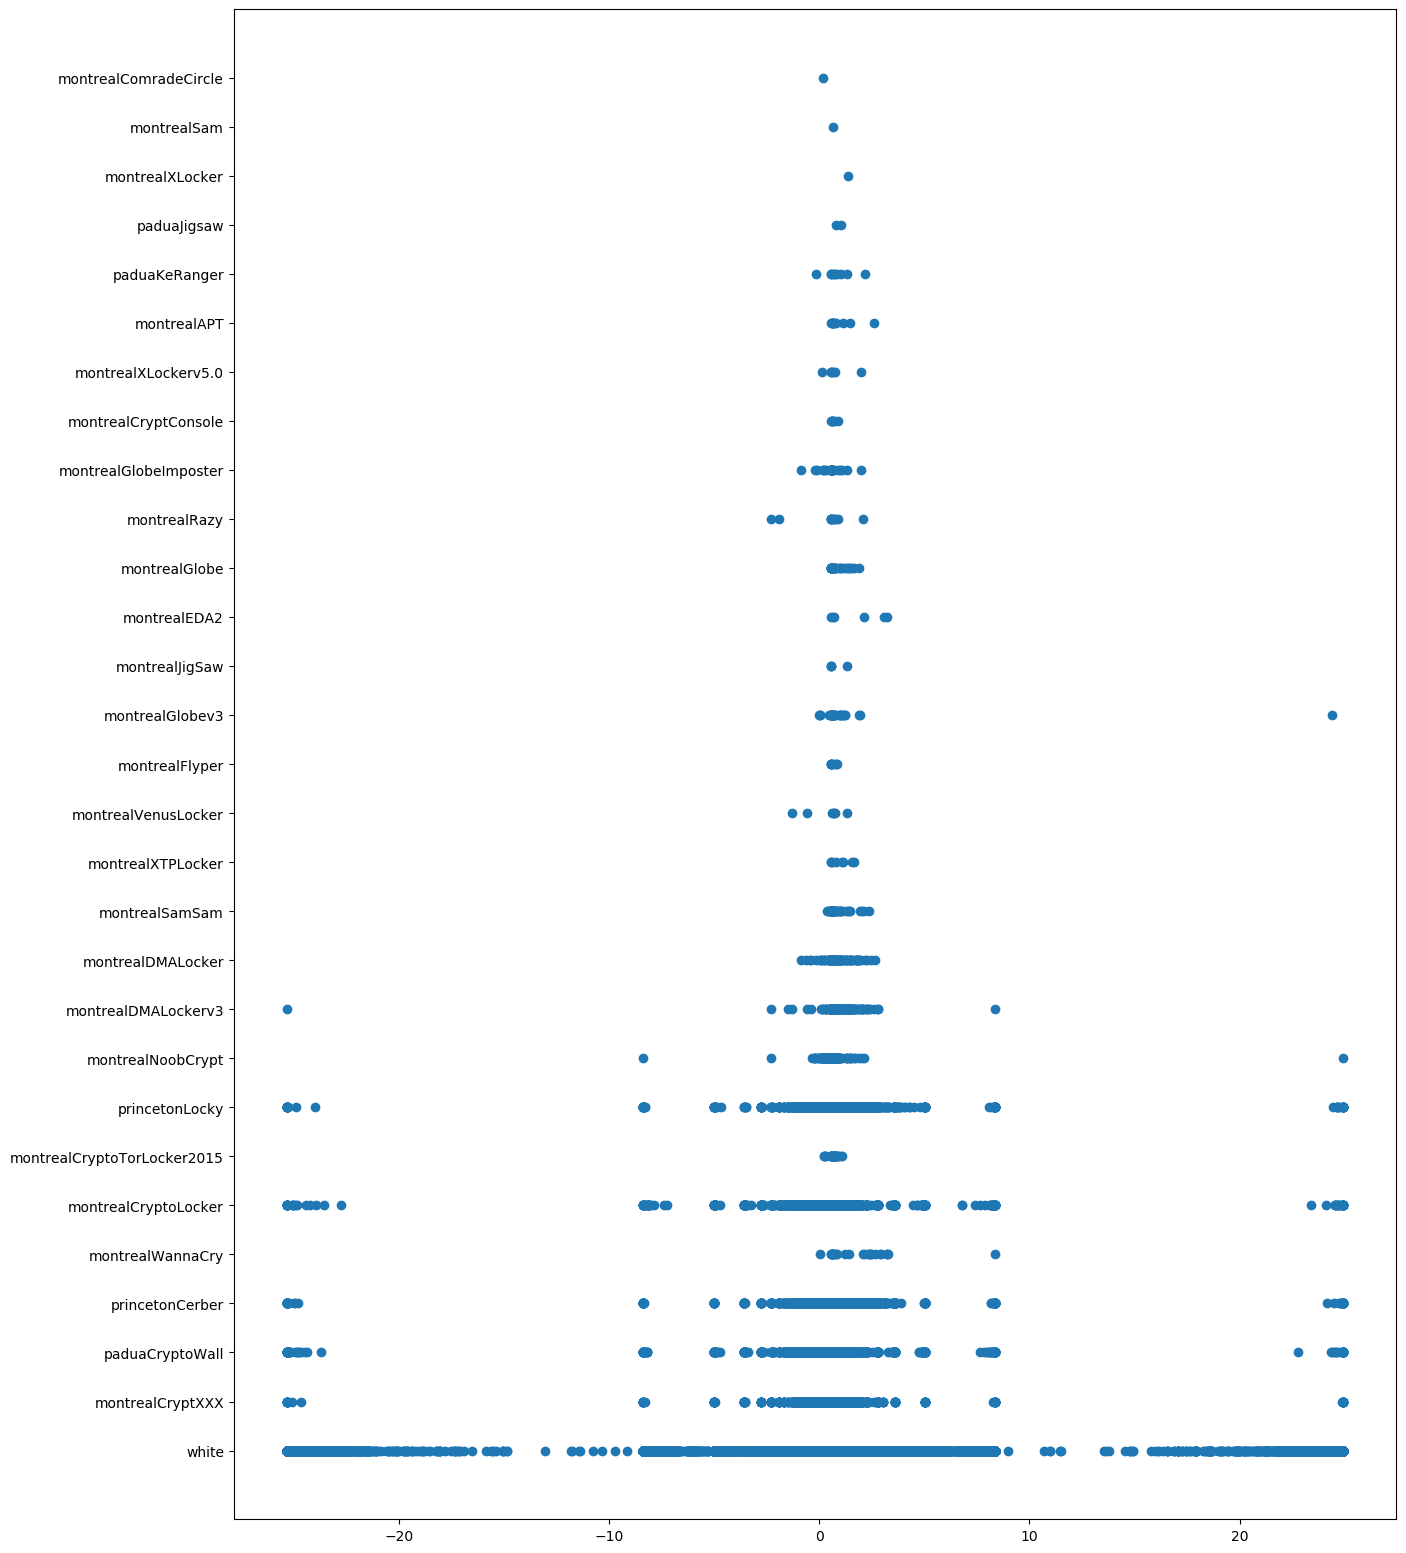

In [27]:
create_new_variable(df,'count', 'length')

In [28]:
df['count_length_ratio'].value_counts()

0.559     687255
0.585     265113
0.613     154575
0.645      86542
0.680      60831
           ...  
4.453          1
6.308          1
6.876          1
4.211          1
13.763         1
Name: count_length_ratio, Length: 7474, dtype: int64

### Dimensionality reduction

<font color='red'>Findings: No values missing - thus no treatment needed for these.

Answer: Not required (only seven feature)

Based on: analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/
- Space required to store the data is reduced as the number of dimensions comes down
- Less dimensions lead to less computation/training time
- Some algorithms do not perform well when we have a large dimensions. So reducing these dimensions needs to happen for the algorithm to be useful
- It takes care of multicollinearity by removing redundant features. For example, you have two variables – ‘time spent on treadmill in minutes’ and ‘calories burnt’. These variables are highly correlated as the more time you spend running on a treadmill, the more calories you will burn. Hence, there is no point in storing both as just one of them does what you require
- It helps in visualizing data. As discussed earlier, it is very difficult to visualize data in higher dimensions so reducing our space to 2D or 3D may allow us to plot and observe patterns more clearly

</font>

## 3. Variable Transformation  <a class="anchor" id="3"></a>

In [29]:
# Standardize the data and take a look at the results
def scale_data(df):
    df_scaled = df.copy()
    scaling_features = ['length', 'weight', 'count', 'looped', 'neighbors', 'income', 'repeated', 'repeated_counter']
    df_scaled[scaling_features] = StandardScaler().fit_transform(df_scaled[scaling_features])
    print(df_scaled.head())
    return df_scaled

In [30]:
df_scaled = scale_data(df)

                              address    length    weight     count    looped  \
0    111111mg3JxXdXbypYNyERcYLaJdzEwb -0.525727 -0.147408 -0.426499 -0.246819   
1    111111mg3JxXdXbypYNyERcYLaJdzEwb -0.390093 -0.131328 -0.425907 -0.246819   
2  111213xkVmeHT1v7N7Ff43XmVfLAUq7WEZ  0.593252 -0.127578 -0.418213 -0.246819   
3  111213xkVmeHT1v7N7Ff43XmVfLAUq7WEZ -0.661360  0.157714 -0.425907 -0.246819   
4  111213xkVmeHT1v7N7Ff43XmVfLAUq7WEZ  0.796703  0.022618 -0.423540 -0.242680   

   neighbors    income  label  binary_label  repeated_counter  repeated  \
0  -0.067333 -0.026829  white             0         -0.135549 -0.047776   
1  -0.011525 -0.026153  white             0          0.053407 -0.047776   
2  -0.067333 -0.026213  white             0         -0.135549  1.271055   
3  -0.011525 -0.026000  white             0          0.053407  1.271055   
4   0.044282 -0.024692  white             0          0.242363  1.271055   

   count_length_ratio  
0               0.811  
1             

## 4. Subdataset creation  <a class="anchor" id="4"></a>

In [31]:
# Create np array of ransomware
# NOTE: changed from deleting value [28] to specific name
def creat_ransomware_df(df):
    ransomware = np.delete(df.label.unique(), df.label.unique().tolist().index('white')) 
    print(ransomware)
    
    # Creating df only about ransomware (unscaled data)
    df_ransomware = df[df.label != 'white']
    print(df_ransomware.head())
    return df_ransomware

In [32]:
# Ransomware data based on df
df_ransomware = creat_ransomware_df(df)

['montrealCryptXXX' 'paduaCryptoWall' 'princetonCerber' 'montrealWannaCry'
 'montrealCryptoLocker' 'montrealCryptoTorLocker2015' 'princetonLocky'
 'montrealNoobCrypt' 'montrealDMALockerv3' 'montrealDMALocker'
 'montrealSamSam' 'montrealXTPLocker' 'montrealVenusLocker'
 'montrealFlyper' 'montrealGlobev3' 'montrealJigSaw' 'montrealEDA2'
 'montrealGlobe' 'montrealRazy' 'montrealGlobeImposter'
 'montrealCryptConsole' 'montrealXLockerv5.0' 'montrealAPT'
 'paduaKeRanger' 'paduaJigsaw' 'montrealXLocker' 'montrealSam'
 'montrealComradeCircle']
                                address    length    weight     count  looped  \
246  112wED5uHhY1aiSaWAzgeMDaCKFcCvj9Pn -0.627452  0.750000 -0.425907       0   
247  112wED5uHhY1aiSaWAzgeMDaCKFcCvj9Pn  0.186351  0.000031 -0.426499       0   
484  113i99LGHX2ZzBed1SaMpnqb6ruRgbBwMc  1.678322  0.243360  0.723426       0   
485  113i99LGHX2ZzBed1SaMpnqb6ruRgbBwMc -0.525727  0.010417 -0.426499       0   
721  114TqaapeRvrQzuwsxQHxLWsg7uYWewx3c -0.763086  1.

In [33]:
# Scaled ransomware data
df_ransomware_scaled = creat_ransomware_df(df_scaled)

['montrealCryptXXX' 'paduaCryptoWall' 'princetonCerber' 'montrealWannaCry'
 'montrealCryptoLocker' 'montrealCryptoTorLocker2015' 'princetonLocky'
 'montrealNoobCrypt' 'montrealDMALockerv3' 'montrealDMALocker'
 'montrealSamSam' 'montrealXTPLocker' 'montrealVenusLocker'
 'montrealFlyper' 'montrealGlobev3' 'montrealJigSaw' 'montrealEDA2'
 'montrealGlobe' 'montrealRazy' 'montrealGlobeImposter'
 'montrealCryptConsole' 'montrealXLockerv5.0' 'montrealAPT'
 'paduaKeRanger' 'paduaJigsaw' 'montrealXLocker' 'montrealSam'
 'montrealComradeCircle']
                                address    length    weight     count  \
246  112wED5uHhY1aiSaWAzgeMDaCKFcCvj9Pn -0.627452  0.055652 -0.425907   
247  112wED5uHhY1aiSaWAzgeMDaCKFcCvj9Pn  0.186351 -0.148462 -0.426499   
484  113i99LGHX2ZzBed1SaMpnqb6ruRgbBwMc  1.678322 -0.082237  0.723426   
485  113i99LGHX2ZzBed1SaMpnqb6ruRgbBwMc -0.525727 -0.145636 -0.426499   
721  114TqaapeRvrQzuwsxQHxLWsg7uYWewx3c -0.763086  0.123693 -0.426499   

       looped  neig

In [34]:
# Count rows and columns
print("Shape of data containing ransomware only :", df_ransomware.shape)
print("Shape of data containing both ransomware and white labels :", df.shape)

Shape of data containing ransomware only : (41413, 12)
Shape of data containing both ransomware and white labels : (2916697, 12)


## 5. Univariate Analysis  <a class="anchor" id="5"></a>

#### 5a. Categorical variables

In [35]:
# Number of addresses used/not used for ransomware
df['binary_label'].value_counts()

0    2875284
1      41413
Name: binary_label, dtype: int64

<font color='red'>Finding: The dataset is high imbalanced. Only 1,14% are ransomware adresses. Challenge is to correctly classify the minority class of ransomware transactions.</font>

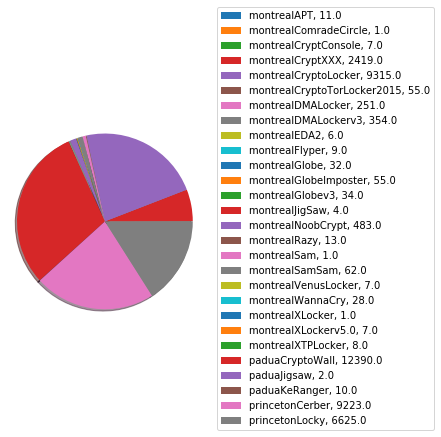

In [36]:
# Creating pie chart to show frequency of ransomware families
# Note: Added the legend and moved the percentage there, so its not overlapped (but still the piechart looks bad)
labels = df_ransomware['label'].astype('category').cat.categories.tolist()
counts = df_ransomware['label'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, shadow=True) #autopct is show the % on plot
ax1.axis('equal')
plt.legend(
    labels = ['%s, %1.1f' % (l, s) for l, s in zip(labels, sizes)],
    bbox_to_anchor=(1,0.5),
    loc="center right", 
    fontsize=10, 
    bbox_transform=plt.gcf().transFigure
)
plt.subplots_adjust(left=0.0, bottom=0.1, right=0.45)
plt.show()


In [37]:
# Count frequency of label
df_ransomware['label'].value_counts().head()

paduaCryptoWall         12390
montrealCryptoLocker     9315
princetonCerber          9223
princetonLocky           6625
montrealCryptXXX         2419
Name: label, dtype: int64

<font color='red'>Finding: The most common is the ransomware CryptoWall, making almost 30% of the ransomware.</font>

#### 5b. Continuous variables

In [38]:
# Create descriptive function for the dataframe
def describeContinuousVars(df):
    # Show central tendency and measure dispersion
    print(df.describe())
    
    df["repeated"].plot.hist()
    plt.show()
    
    # Create boxplots (Divided in three charts)
    df.boxplot(column=['repeated', 'length', 'repeated_counter'])
    plt.show()
    
    # Create boxplots (Divided in three charts)
    df.boxplot(column=['weight', 'count', 'looped'])
    plt.show()
    
    # Create boxplots (Divided in three charts)
    df.boxplot(column=['neighbors', 'income'])
    plt.show()

             length        weight         count        looped     neighbors  \
count  2.916697e+06  2.916697e+06  2.916697e+06  2.916697e+06  2.916697e+06   
mean  -7.189116e-13 -6.621340e-14 -1.759770e-13  1.100264e-12 -8.368568e-14   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -7.630858e-01 -1.484707e-01 -4.264988e-01 -2.468192e-01 -6.733256e-02   
25%   -7.291773e-01 -1.426234e-01 -4.264988e-01 -2.468192e-01 -6.733256e-02   
50%   -6.274520e-01 -8.042971e-02 -4.264988e-01 -2.468192e-01 -1.152513e-02   
75%    1.067970e+00  9.156387e-02 -3.939482e-01 -2.468192e-01 -1.152513e-02   
max    1.678322e+00  5.288701e+02  8.152663e+00  1.475440e+01  7.209088e+02   

             income  binary_label  repeated_counter      repeated  \
count  2.916697e+06  2.916697e+06      2.916697e+06  2.916697e+06   
mean  -5.668007e-15  1.419860e-02      1.276526e-12 -2.259419e-12   
std    1.000000e+00  1.183089e-01      1.000000e+00  1.000000e+00   
min   -2.726

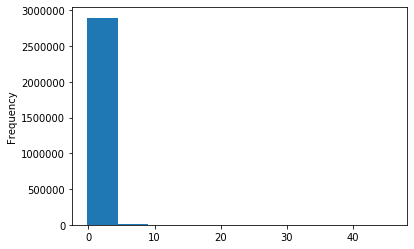

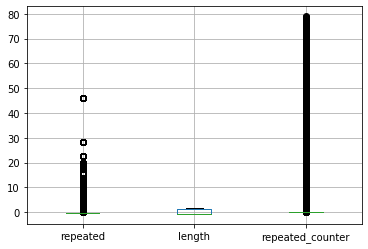

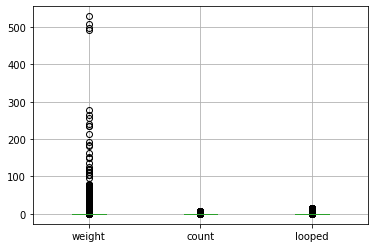

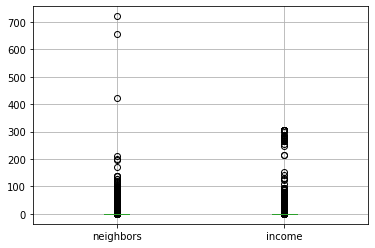

In [39]:
# Visualize the scaled dataset
describeContinuousVars(df_scaled)

<font color='red'>As I've read more about anomalies and noisy data detection, the best ways are apparently to look at the boxplots. Since we have them, its easier to see there are some features that have outliers, specifically: neighbors, repeated, weight.

Another good way is to look at the variance of the features, and if it is high then there is some noise present.</font>

             length        weight         count        looped     neighbors  \
count  2.916697e+06  2.916697e+06  2.916697e+06  2.916697e+06  2.916697e+06   
mean  -7.189116e-13  5.455192e-01 -1.759770e-13  2.385067e+02  2.206516e+00   
std    1.000000e+00  3.674255e+00  1.000000e+00  9.663217e+02  1.791877e+01   
min   -7.630858e-01  3.606469e-94 -4.264988e-01  0.000000e+00  1.000000e+00   
25%   -7.291773e-01  2.148438e-02 -4.264988e-01  0.000000e+00  1.000000e+00   
50%   -6.274520e-01  2.500000e-01 -4.264988e-01  0.000000e+00  2.000000e+00   
75%    1.067970e+00  8.819482e-01 -3.939482e-01  0.000000e+00  2.000000e+00   
max    1.678322e+00  1.943749e+03  8.152663e+00  1.449600e+04  1.292000e+04   

             income  binary_label  repeated_counter      repeated  \
count  2.916697e+06  2.916697e+06      2.916697e+06  2.916697e+06   
mean   4.464889e+09  1.419860e-02      1.717357e+00  2.434715e+00   
std    1.626860e+11  1.183089e-01      5.292234e+00  9.098970e+00   
min    3.000

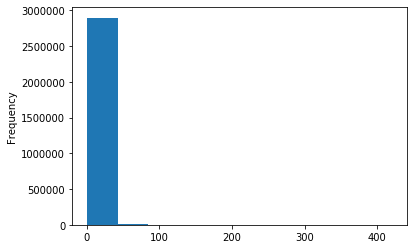

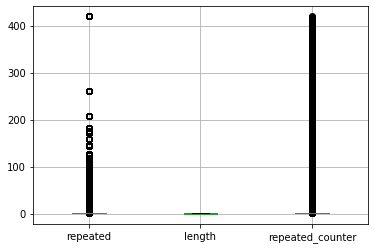

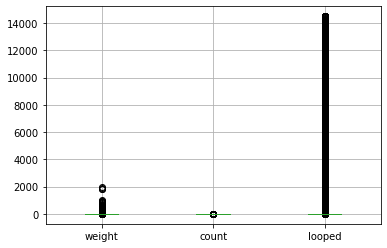

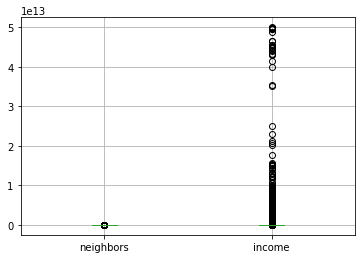

In [40]:
# Visualize the original dataset
describeContinuousVars(df)

<font color='red'>Finding: It seem that we have outliers for weight and repeated. In the following, it will be further investigated</font>

## 6. Bi-variate Analysis  <a class="anchor" id="6"></a>

In [41]:
# Function to explore correlation
def explore_correlation(df):
    
    # Creat Scatter matrix
    if False:
        scatter_matrix(df_ransomware_scaled, figsize = (14, 9));
    
    ### Correlation Matrix for 1st RQ
    print(df.corr())

    #-1: perfect negative linear correlation
    # +1:perfect positive linear correlation and 
    # 0: No correlation
    
    # Plot the correlations per Regions 
    plt.rcParams['figure.figsize'] = (14,12)
    sns.heatmap(df.corr(), annot = True)
    plt.show()

                      length    weight     count    looped  neighbors  \
length              1.000000  0.000228  0.703467  0.411609   0.031523   
weight              0.000228  1.000000  0.022313  0.061646   0.691963   
count               0.703467  0.022313  1.000000  0.560370   0.025441   
looped              0.411609  0.061646  0.560370  1.000000   0.052826   
neighbors           0.031523  0.691963  0.025441  0.052826   1.000000   
income              0.000488  0.069774 -0.003635  0.002551   0.138966   
binary_label       -0.006860  0.002676 -0.008654 -0.017810  -0.000872   
repeated_counter   -0.051886  0.023333 -0.037486 -0.014875   0.024512   
repeated           -0.055968  0.030467 -0.044624 -0.017909   0.035867   
count_length_ratio -0.000006  0.003593  0.134400  0.071524   0.001359   

                      income  binary_label  repeated_counter  repeated  \
length              0.000488     -0.006860         -0.051886 -0.055968   
weight              0.069774      0.002676      

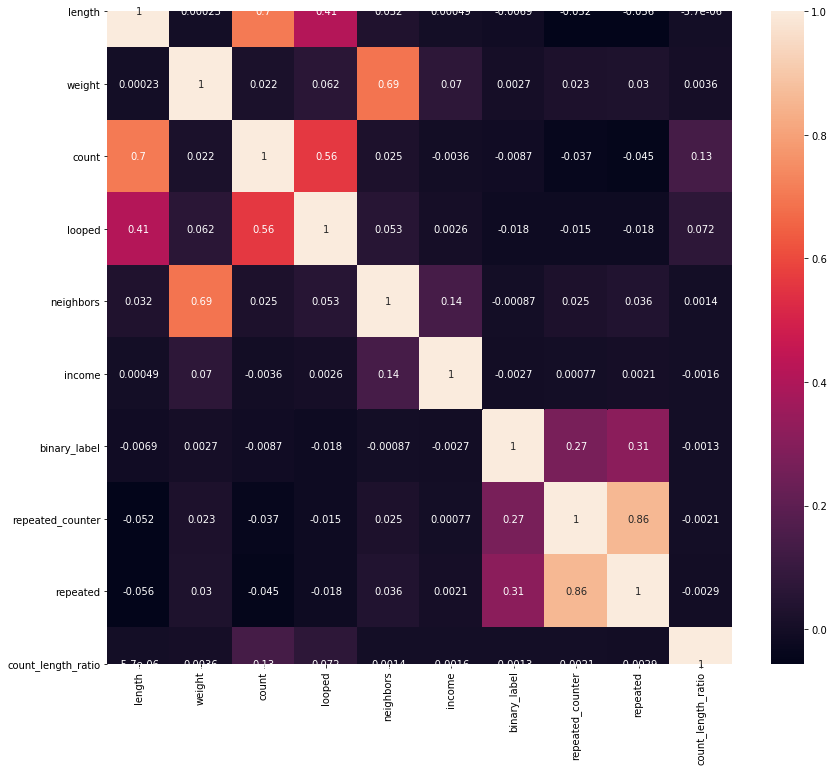

In [42]:
explore_correlation(df)

<font color='red'>Findings:
- Between repeated and label is weak positive correlation
- Between the other features and label exist no direct correlation
- Between count and looped is a correlation
- Between count and length is a strong correlation
- Between looped and length is a strong correlation
- Betweeen weight and neigbours is a correlation

</font>

## 7. Outlier handling <a class="anchor" id="7"></a>

### 7a. Outlier detection using boxplots 

In [43]:
# Investigate potential outlier in 'repeated' column
df.iloc[df['repeated'].idxmax()]

address               1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU
length                                         -0.729177
weight                                               0.5
count                                          -0.426499
looped                                                 0
neighbors                                              1
income                                       2.53669e+09
label                               montrealCryptoLocker
binary_label                                           1
repeated_counter                                       1
repeated                                             420
count_length_ratio                                 0.585
Name: 291872, dtype: object

<font color='red'>
Repeated: Its a ransomware address. Therefore, it should remain in the dataset </font>

In [44]:
# Investigate potential outlier in 'weight' column
df.iloc[df['weight'].idxmax()]

address                   unknown
length                    1.67832
weight                    1943.75
count                     1.92543
looped                       3975
neighbors                   12920
income                6.51006e+12
label                       white
binary_label                    0
repeated_counter                4
repeated                        4
count_length_ratio          1.147
Name: 382368, dtype: object

In [45]:
# Show rows, where weight is above 800
df[df['weight'] > 800]

,address,length,weight,count,looped,neighbors,income,label,binary_label,repeated_counter,repeated,count_length_ratio
11762,12cgpFdJViXbwHbhrA3TuW1EGnL25Zqc3P,1.678322,1804.614640,5.129006,9388,387,2.142067e+12,white,0,5,13,3.056
319158,1NDyJtNTjmwk5xPNhjgAMu4HDHigtobu1s,1.678322,974.863015,3.199049,6127,968,9.222508e+11,white,0,3,4,1.906
365823,3422VtS7UtCvXYxoXMVp6eZupR252z85oC,-0.695269,881.477311,-0.109278,537,1233,2.116113e+11,white,0,3,6,0.157
365824,3422VtS7UtCvXYxoXMVp6eZupR252z85oC,-0.695269,938.693486,-0.100993,551,984,1.537817e+11,white,0,4,6,0.145
382366,unknown,1.678322,1827.778835,2.397120,4772,7589,3.097054e+12,white,0,2,4,1.428
382367,unknown,1.678322,1866.716729,2.934502,5680,11746,1.067816e+13,white,0,3,4,1.748
382368,unknown,1.678322,1943.748793,1.925432,3975,12920,6.510062e+12,white,0,4,4,1.147
1832099,1L671pxzdY9dzEayZ9yEfUVWAoGsq99PoC,1.678322,1019.849456,4.366137,8099,336,3.248000e+12,white,0,1,1,2.601
2337778,1KqB2s2E9euz821zbwoMZMiMmT2GLMRsan,1.678322,866.603101,5.121904,9376,1655,2.391087e+11,white,0,1,1,3.052
2338440,33fDiKKhr2F2uRv2jJzdKT3ECuK3wzCq5d,1.678322,864.924781,5.121904,9364,1389,1.982364e+11,white,0,1,1,3.052


In [46]:
# How many addresses are unknown
df[df.address == 'unknown']

,address,length,weight,count,looped,neighbors,income,label,binary_label,repeated_counter,repeated,count_length_ratio
382365,unknown,1.678322,146.137741,2.645097,4812,1192,6.625257e+11,white,0,1,4,1.576
382366,unknown,1.678322,1827.778835,2.397120,4772,7589,3.097054e+12,white,0,2,4,1.428
382367,unknown,1.678322,1866.716729,2.934502,5680,11746,1.067816e+13,white,0,3,4,1.748
382368,unknown,1.678322,1943.748793,1.925432,3975,12920,6.510062e+12,white,0,4,4,1.147


In [47]:
# Length of the bitcoin address (must be between 26-35 alphanumeric characters)
df['address'].astype(str).map(len).value_counts()

34    2808961
33     107728
7           4
32          3
27          1
Name: address, dtype: int64

<font color='red'>
Findings for Weight:
1. Some addresses are unknown (Note: Address. A Bitcoin address, or simply address, is an identifier of 26-35 alphanumeric characters, beginning with the number 1 , 3 or bc1 that represents a possible destination for a bitcoin payment.
2. Bug gap between the values (1019 vs. 1804) 
    
Therefore, the rows with the address.len below 26 characters and the weight above 1100 should be deleted in the dataframe 'df' and 'df_scaled'. </font>

### 7b. Outlier elimination using boxplots 

In [48]:
# Drop every row below 26 characters
df = df.drop(df[df.address.map(len) <  26].index)

# Check if the drop were successful
print(df[df['address'].map(len) < 26])

Empty DataFrame
Columns: [address, length, weight, count, looped, neighbors, income, label, binary_label, repeated_counter, repeated, count_length_ratio]
Index: []


In [49]:
# # Drop every row, where weight is above 1100
df = df.drop(df[df.weight > 1100].index)

# Check if the drop were successful
print(df[df['weight'] > 1100])

Empty DataFrame
Columns: [address, length, weight, count, looped, neighbors, income, label, binary_label, repeated_counter, repeated, count_length_ratio]
Index: []


In [50]:
# Update the dataframe df_scaled
df_scaled = scale_data(df)

                              address    length    weight     count    looped  \
0    111111mg3JxXdXbypYNyERcYLaJdzEwb -0.525725 -0.182286 -0.426497 -0.246817   
1    111111mg3JxXdXbypYNyERcYLaJdzEwb -0.390091 -0.162305 -0.425905 -0.246817   
2  111213xkVmeHT1v7N7Ff43XmVfLAUq7WEZ  0.593255 -0.157646 -0.418212 -0.246817   
3  111213xkVmeHT1v7N7Ff43XmVfLAUq7WEZ -0.661359  0.196851 -0.425905 -0.246817   
4  111213xkVmeHT1v7N7Ff43XmVfLAUq7WEZ  0.796706  0.028984 -0.423538 -0.242677   

   neighbors    income  label  binary_label  repeated_counter  repeated  \
0  -0.085283 -0.026810  white             0         -0.135549 -0.047776   
1  -0.013912 -0.026133  white             0          0.053407 -0.047776   
2  -0.085283 -0.026193  white             0         -0.135549  1.271054   
3  -0.013912 -0.025980  white             0          0.053407  1.271054   
4   0.057460 -0.024671  white             0          0.242363  1.271054   

   count_length_ratio  
0               0.811  
1             

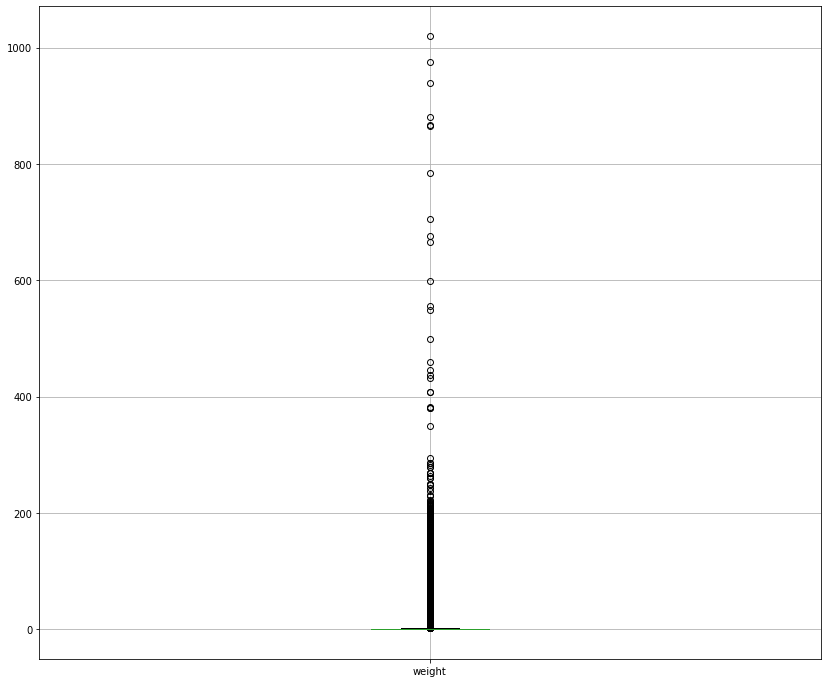

In [51]:
# Plot column weight again
df.boxplot(column=['weight'])
plt.show()

             length        weight         count        looped     neighbors  \
count  2.916689e+06  2.916689e+06  2.916689e+06  2.916689e+06  2.916689e+06   
mean   1.018975e-13 -8.989214e-14 -3.230235e-12  1.178123e-12  1.829637e-13   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -7.630844e-01 -1.836065e-01 -4.264973e-01 -2.468170e-01 -8.528295e-02   
25%   -7.291759e-01 -1.763409e-01 -4.264973e-01 -2.468170e-01 -8.528295e-02   
50%   -6.274505e-01 -9.906049e-02 -4.264973e-01 -2.468170e-01 -1.391169e-02   
75%    1.067974e+00  1.146532e-01 -3.939465e-01 -2.468170e-01 -1.391169e-02   
max    1.678327e+00  3.447134e+02  8.152729e+00  1.475485e+01  2.693412e+02   

             income  binary_label  repeated_counter      repeated  \
count  2.916689e+06  2.916689e+06      2.916689e+06  2.916689e+06   
mean  -1.918794e-14  1.419863e-02     -2.574397e-12  5.776459e-12   
std    1.000000e+00  1.183091e-01      1.000000e+00  1.000000e+00   
min   -2.724

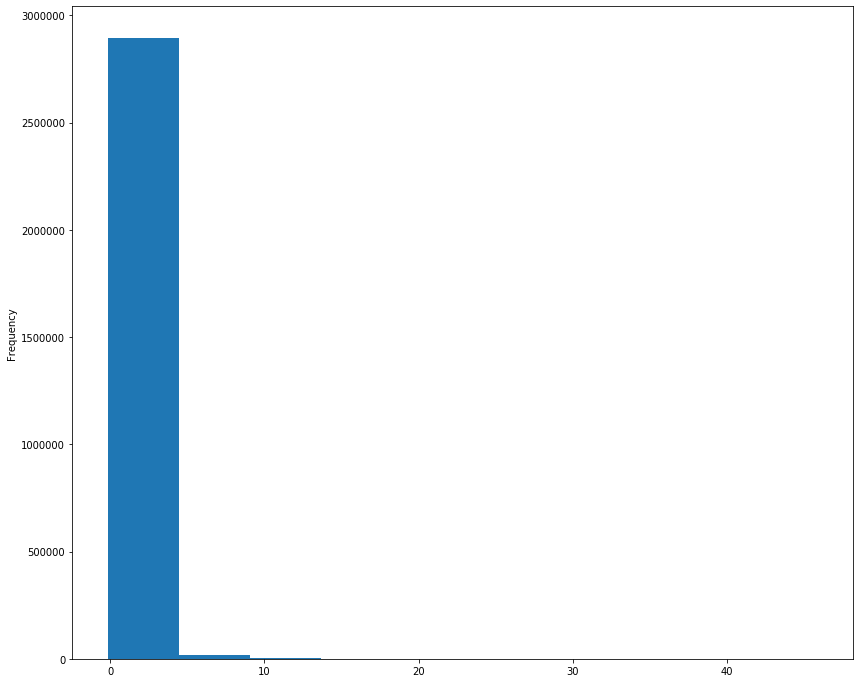

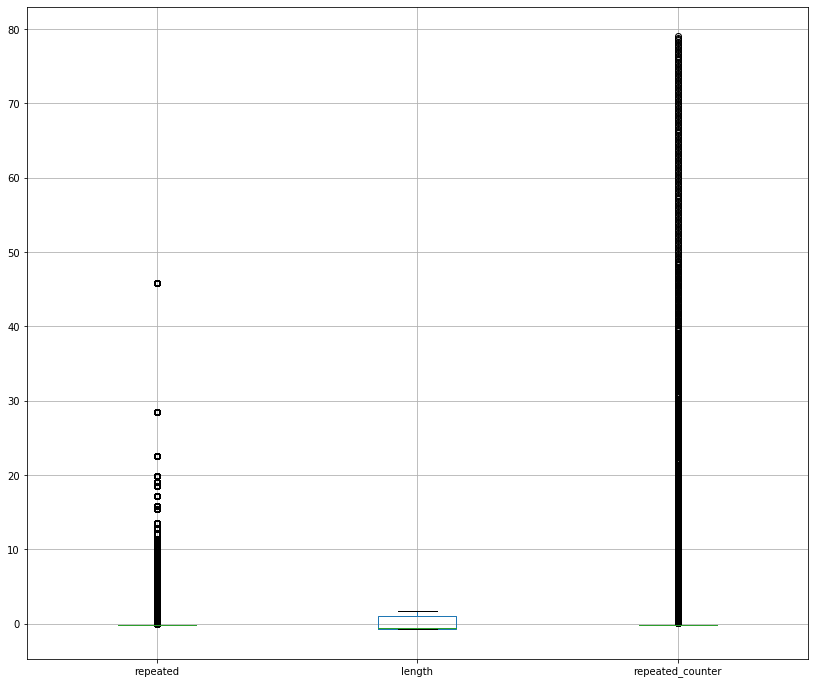

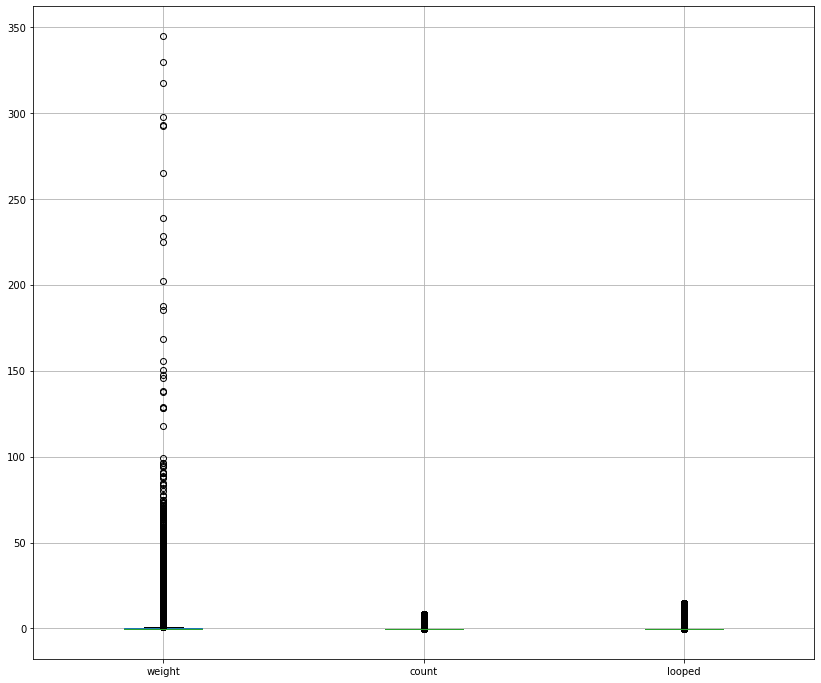

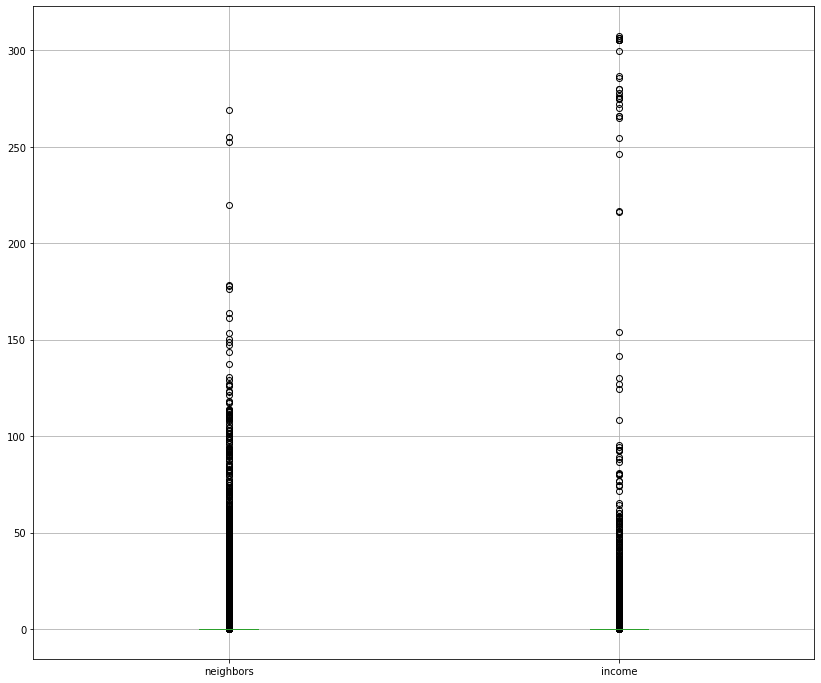

In [52]:
# Check Results after outlier elimnation of the scaled version
describeContinuousVars(df_scaled)

In [53]:
# Update the dataframe Scaled ransomware data
df_ransomware_scaled = creat_ransomware_df(df_scaled)

['montrealCryptXXX' 'paduaCryptoWall' 'princetonCerber' 'montrealWannaCry'
 'montrealCryptoLocker' 'montrealCryptoTorLocker2015' 'princetonLocky'
 'montrealNoobCrypt' 'montrealDMALockerv3' 'montrealDMALocker'
 'montrealSamSam' 'montrealXTPLocker' 'montrealVenusLocker'
 'montrealFlyper' 'montrealGlobev3' 'montrealJigSaw' 'montrealEDA2'
 'montrealGlobe' 'montrealRazy' 'montrealGlobeImposter'
 'montrealCryptConsole' 'montrealXLockerv5.0' 'montrealAPT'
 'paduaKeRanger' 'paduaJigsaw' 'montrealXLocker' 'montrealSam'
 'montrealComradeCircle']
                                address    length    weight     count  \
246  112wED5uHhY1aiSaWAzgeMDaCKFcCvj9Pn -0.627450  0.070032 -0.425905   
247  112wED5uHhY1aiSaWAzgeMDaCKFcCvj9Pn  0.186353 -0.183596 -0.426497   
484  113i99LGHX2ZzBed1SaMpnqb6ruRgbBwMc  1.678327 -0.101306  0.723436   
485  113i99LGHX2ZzBed1SaMpnqb6ruRgbBwMc -0.525725 -0.180084 -0.426497   
721  114TqaapeRvrQzuwsxQHxLWsg7uYWewx3c -0.763084  0.154578 -0.426497   

       looped  neig

In [54]:
# Update the dataframe ransomware data
df_ransomware = creat_ransomware_df(df)

['montrealCryptXXX' 'paduaCryptoWall' 'princetonCerber' 'montrealWannaCry'
 'montrealCryptoLocker' 'montrealCryptoTorLocker2015' 'princetonLocky'
 'montrealNoobCrypt' 'montrealDMALockerv3' 'montrealDMALocker'
 'montrealSamSam' 'montrealXTPLocker' 'montrealVenusLocker'
 'montrealFlyper' 'montrealGlobev3' 'montrealJigSaw' 'montrealEDA2'
 'montrealGlobe' 'montrealRazy' 'montrealGlobeImposter'
 'montrealCryptConsole' 'montrealXLockerv5.0' 'montrealAPT'
 'paduaKeRanger' 'paduaJigsaw' 'montrealXLocker' 'montrealSam'
 'montrealComradeCircle']
                                address    length    weight     count  looped  \
246  112wED5uHhY1aiSaWAzgeMDaCKFcCvj9Pn -0.627452  0.750000 -0.425907       0   
247  112wED5uHhY1aiSaWAzgeMDaCKFcCvj9Pn  0.186351  0.000031 -0.426499       0   
484  113i99LGHX2ZzBed1SaMpnqb6ruRgbBwMc  1.678322  0.243360  0.723426       0   
485  113i99LGHX2ZzBed1SaMpnqb6ruRgbBwMc -0.525727  0.010417 -0.426499       0   
721  114TqaapeRvrQzuwsxQHxLWsg7uYWewx3c -0.763086  1.

 ## 8. Missing Values <a class="anchor" id="8"></a>

In [55]:
# Count missing value
df.isnull().sum()

address               0
length                0
weight                0
count                 0
looped                0
neighbors             0
income                0
label                 0
binary_label          0
repeated_counter      0
repeated              0
count_length_ratio    0
dtype: int64

<font color='red'>Findings: No values missing - thus no treatment needed for these.</font>

## 9. Principal component analysis <a class="anchor" id="09"></a>

In [56]:
def perform_pca(df, features, label):
    X = df[features]
    y = df[label]
    
    #PCA Projection to 2D
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
    
    y.reset_index(drop=True, inplace=True)
    principalDf.reset_index(drop=True, inplace=True)
    
    pcaDF = pd.concat([principalDf, y], axis = 1)
    print(pcaDF.head(10))
    
    print(pca.explained_variance_ratio_)
    
    # Visualize 2D Projection
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = [0, 1]
    colors = ['r', 'g']
    for target, color in zip(targets , colors):
        indicesToKeep = pcaDF[label] == target
        ax.scatter(pcaDF.loc[indicesToKeep, 'principal component 1']
                   , pcaDF.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50)
        ax.legend(targets)
        ax.grid()

In [57]:
features = ['length', 'weight', 'count',
            'looped','neighbors', 'income',
            'repeated', 'repeated_counter','count_length_ratio']

In [58]:
original_features = ['length', 'weight', 'count',
                     'looped','neighbors', 'income']

#### 9a. PCA: df_scaled with extended features

   principal component 1  principal component 2  binary_label
0              -0.132432              -0.665608             0
1              -0.414010              -0.637741             0
2               1.367320              -0.188614             0
3               0.038061              -0.993186             0
4               1.192544              -0.134074             0
5              -0.033944              -1.032507             0
6              -4.203573              -0.989780             0
7               1.051723              -0.050436             0
8               1.083672              -0.130957             0
9              -0.321178              -1.110987             0
[0.44342863 0.14959836]


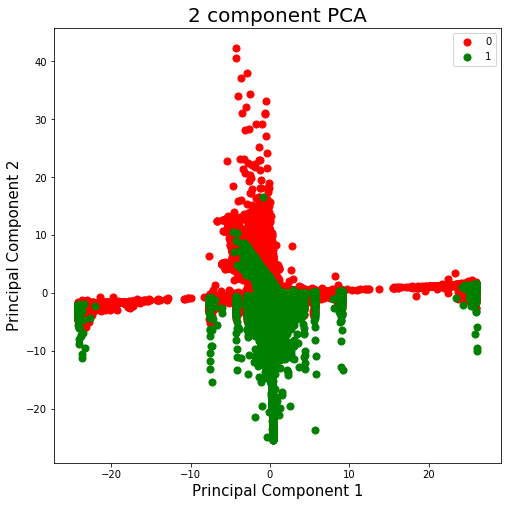

In [59]:
perform_pca(df_scaled, features, 'binary_label')

#### 9b.  PCA: df_scaled with orginal features

   principal component 1  principal component 2  binary_label
0              -0.720986              -0.061522             0
1              -0.632191              -0.015835             0
2              -0.075323              -0.182970             0
3              -0.747036               0.258856             0
4               0.078023               0.015940             0
5              -0.706566               0.247107             0
6              -0.303290               0.764786             0
7               0.304816               0.381848             0
8               0.256532               0.360612             0
9              -0.616357               0.201659             0
[0.35679455 0.26817563]


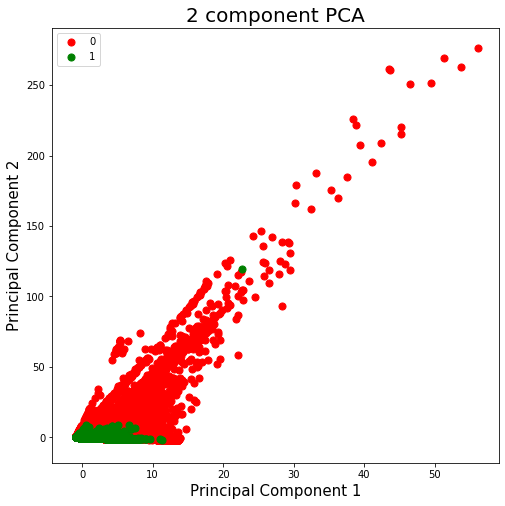

In [60]:
perform_pca(df_scaled, original_features, 'binary_label')

#### 9c.  PCA: df_ransomware_scaled with extended features

In [61]:
def perform_pca_multi_label(df, features, label):
    X = df[features]
    y = df[label]
    
    #PCA Projection to 2D
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
    
    print(pca.explained_variance_ratio_)

In [62]:
perform_pca_multi_label(df_ransomware_scaled, features, 'label')

[0.84289274 0.07102135]


#### 9d.  PCA: df_ransomware_scaled with original features

In [63]:
perform_pca_multi_label(df_ransomware_scaled, original_features, 'label')

[0.53768296 0.29097299]


<font color = "red"> Interpretation of PCA results:
When using the explained variance ratio, one can see how much information can be attributed to each of the principal components. Because the conversion was from a 7 dimensional space to a 2D one, of course we lost some information. Thus, the first component can explain 94% of the total information (contains 94% variance), and then second component only 3%.
    
I tried to see how it would work with more principal components, by changing n_components, but the results are irrelevant I think - because we just get components with very minimal variance.
</font>

<font color = "purple"> TO DO: Recheck results </font>

## 10. Export dataframes <a class="anchor" id="10"></a>

In [64]:
# Desired order for the dataframnes (label at the end)
column_names = ['address','length','weight',
                'count', 'looped','neighbors',
                'income', 'repeated', 'repeated_counter', 'label', 'binary_label']

In [65]:
# Adapt the dataframes to the desired order
df = df[column_names]
df_scaled = df_scaled[column_names]
df_ransomware = df_ransomware[column_names]
df_ransomware_scaled = df_ransomware_scaled[column_names]

In [66]:
# Check df before exporting
if True:
    df_ransomware.head()

In [67]:
# Export dataframes to csv.format
if True:
    df.to_csv('df.csv',index = bool)
    df_scaled.to_csv('df_scaled.csv')
    df_ransomware.to_csv('df_ransomware.csv')
    df_ransomware_scaled.to_csv('df_ransomware_scaled.csv')